# Starbucks Capstone Challenge
_____________________________________________________

In this Udacity Machine Learning Nanodegree Capstone project I am going to analyse and process data that mimics customer behavior on the Starbucks rewards mobile app. 

The goal is to find an answer to a real business question: is a customers going to buy something in the influence of a certain offer based on past customer behaviour?

I will build a machine learning model that can answer to that problem. When customer and offer details are given to the model it will predict if the customer will make a purchase on Starbucks or not. We can measure how well a model performs by checking the percentage of correctly predicted rows.

**THE PROJECT WORKFLOW:**

**Preparation**
- Downloading data
- Familiarising with the data

**Preprocessing**
- Gathering relevant data from different sources
- Making the data machine readable

**Machine learning models**
- Benchmark model: Decision tree classifier
- Testing with other models
- Fine tuning the best model

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

## PREPARATION
___________________________________________

### Familiarising with the data

First, let's download the data from json files to dataframes and see what we got.

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1) Portfolio

Portfolio has the data about offers sent to customers. In this case there are 10 different offers.

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [3]:
portfolio[['id','offer_type', 'duration', 'difficulty','reward','channels']]

,id,offer_type,duration,difficulty,reward,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,20,5,"[web, email]"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,"[web, email, mobile, social]"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,"[web, email, mobile, social]"
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,"[email, mobile, social]"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"[web, email, mobile, social]"
9,2906b810c7d4411798c6938adc9daaa5,discount,7,10,2,"[web, email, mobile]"


### 2) Profile

Profile table contains information of the customers.

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer ('F', 'M' and 'O' for other)
* id (str) - customer id
* income (float) - customer's income

In [4]:
profile[['id', 'gender', 'age', 'income', 'became_member_on']].head()

,id,gender,age,income,became_member_on
0,68be06ca386d4c31939f3a4f0e3dd783,None,118,NaN,20170212
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,20170715
2,38fe809add3b4fcf9315a9694bb96ff5,None,118,NaN,20180712
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,20170509
4,a03223e636434f42ac4c3df47e8bac43,None,118,NaN,20170804


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


One strange detail quickly drew my attention - there were multiple customers with age of 118. With more inspection seems like it is just a placeholder for null value, since seems like gender and income are nulls as well.

These kind of customers are probably not sharing their personal information.

In [6]:
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

#### Age and gender visualization

We could visualize the customer distribution a bit.

Text(0,0.5,'Number')

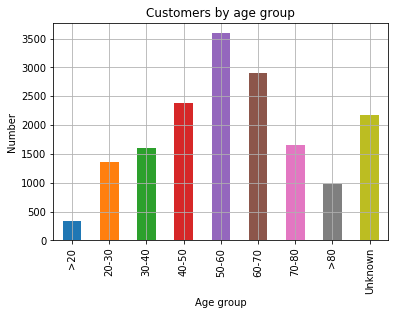

In [7]:
# Separate ages to age groups to make the data easier to view
def set_age_groups(data):   
    data['age'] = data.age.fillna(118)
    bins = (0, 20, 30, 40, 50, 60, 70, 80, 117, 120)
    edges = ['>20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80', 'Unknown']
    categories = pd.cut(data.age, bins, labels=edges)
    data['age'] = categories
    return data
    
profile_age_grouped = set_age_groups(profile.copy())

ages = profile_age_grouped.groupby(['age']).size().plot(
                                        kind='bar',
                                        stacked=False, 
                                        grid=True, 
                                        title='Customers by age group')
ages.set_xlabel("Age group")
ages.set_ylabel("Number")

Text(0,0.5,'Number')

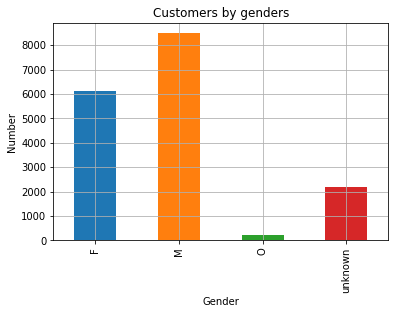

In [8]:
profile_age_grouped['gender'].fillna('unknown', inplace=True)
genders = profile_age_grouped.groupby(['gender']).size().plot(
                                    kind='bar',
                                    stacked=False, 
                                    grid=True, 
                                    title='Customers by genders')
genders.set_xlabel("Gender")
genders.set_ylabel("Number")

### 3) Transcript

From this table you can find events connected to customers and offers. The value column contains some relevant info (offer id, amount and/of reward) in a dictionary.

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [9]:
transcript.sort_values(by=['person', 'time']).head()

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}



**Significant observations:**

- One offer can have three statuses: received, viewed and completed. Logically, an offer cannot be viewed or completed before it is received. However, it can be completed without being viewed. In this case you could say the offer did not affect the customer.

- A customer can get the same offer several times. In any case, each of them would be good to be considered separate to get better results when evaluating how an offer affected customers.

- Transactions cannot be connected to offers and one transaction can complete multiple offers. Than means you cannot tell how much a customer spent when completing an offer.

- If the offer sent is an informational offer there is no status ‘offer completed’. Instead, transactions during the offer duration has to be checked.

**Other thoughts:**
- The age distribution seems peculiar. I was surprised to see the biggest age groups using the Starbucks mobile app are 50-60, 60-70 and 40-50 when customers on their 20's and 30's are not represented in these numbers that much.

- When examining the data it is good to keep in mind this is data from 17 000 customers collected in 30 (29,75) days.

## PREPROCESSING - GATHERING DATA
___________________________________________

To make the data nice to analyze and for our machine learning model to use, let's collect a dataframe combining all interesting data from our existing source tables.


### Reactions to offers

First let's see how each customer has reacted to each offer.

I will collect customer actions from transcript data and see if a customer saw an offer and made a purchase in the influence of it. We need to handle informational and other offers separately, since you cannot really complete an informational offer.

First let's preprocess the transcript dataframe. It contains lots of important data in value field so we need to extract that from there.

In [10]:
# opening the value field of transcript to get the data to separate columns 
# (this takes a while)
actions = transcript.copy()
actions = pd.concat([actions.drop(['value'], axis=1), actions['value'].apply(pd.Series)], axis=1)

In [11]:
actions.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [12]:
# It seems there are offer ids in two columns, 'offer id' and 'offer_id'. 
# Combining those.

def combine_offer_id_cols(data):
    data['offer id'] = data['offer id'].fillna(data['offer_id'])
    data.drop(['offer_id'], inplace=True, axis=1)
    return data

combine_offer_id_cols(actions)

actions.head()

,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Now that the table is nice and easy to handle let's gather data depending on offer type.

#### Offers that can be completed (bogo, discount)

These kind of offers have three events: received, viewed and completed. If one person has offer with all those events, you can say the offer influenced the person.

If the offer was not viewed, was viewed but not completed or viewed and completed outside the time frame I reckon the customer was not effected by the offer.

In [13]:
# Collecting offer events from actions
offer_events = actions[(actions['event']=='offer received') 
                          | (actions['event']=='offer viewed')
                          | (actions['event']=='offer completed')]

Since one customer can get one specific offer more than once and I want to view reactions to all of them I need to keep on track how many times an offer is received. 

That's why I am adding a cumulative counter based on person id, offer id and event (received/viewed/completed). For example when a customer receives a specific offer the first time the count is 0, the second time 1 and so on. In that way I can combine the rows based on offer id later without losing any rows.

In [14]:
offer_events = offer_events.sort_values(by=['time'])
offer_events['offer_count'] = offer_events.groupby(['person', 'offer id', 'event']).cumcount()

As an example, here are the actions of one random person. We can see they have received offer with the id 9b98b8c7a33c4b65b9aebfe6a799e6d9 three times.

In [15]:
example_person_actions = offer_events[offer_events['person'] == '4b72995c52ab4cd5ab407924b09e1ab4']
example_person_actions[['offer id', 'event', 'time', 'offer_count']].head(12).sort_values(by=['time'])

,offer id,event,time,offer_count
11212,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0
20068,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,12,0
41906,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,96,0
64402,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,1
76970,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,186,1
83190,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,204,1
122070,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,336,2
126777,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,336,2
126779,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,336,2
161902,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,408,3


To understand if a customer was really effected by an offer we need to check if it was read before completion and completed within the offer time frame.

I am adding the duration of the offer (days) to each row and also the time (hours since starting of the test) when action happened.

In [16]:
# Collect offer duration from portfolio 
offers = portfolio.copy()
offer_events['offer_duration'] = offer_events['offer id'].map(offers.set_index('id')['duration'])

I'm also moving all events connected to unique offer to one row. This is called one-hot-encoding.

In [17]:
# Moving events column values to separate columns (one-hot-encoding)
# so that we can see which actions were made

offer_events = pd.concat([offer_events, 
                    pd.get_dummies(offer_events['event'], 
                    prefix=None)], 
                    axis=1)
offer_events.drop(['event'], axis=1, inplace=True)

Also, it helps us to determine if an offer had an effect if we also add times when each event happened.

In [18]:
# Adding times to correct columns

offer_events.loc[offer_events['offer received'] == 1, 'received time'] = offer_events['time']
offer_events.loc[offer_events['offer viewed'] == 1, 'viewed time'] = offer_events['time']
offer_events.loc[offer_events['offer completed'] == 1, 'completion time'] = offer_events['time']

Now that all the data is correctly edited we can group the rows by person, offer id and offer count so that each offer sent to each customer will be one row only.

In [19]:
aggregation_functions = {
    'offer received': 'sum', 
    'offer viewed': 'sum',
    'offer completed': 'sum', 
    'reward': 'sum',
    'offer_duration': 'first',
    'received time': 'first',
    'viewed time': 'first',
    'completion time': 'first'}

offer_events = offer_events.groupby(['person','offer id','offer_count']).aggregate(aggregation_functions)

In [20]:
offer_events.tail(8)

offer received  \
person                           offer id                         offer_count                   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                         1   
                                                                  1                         1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                         1   
                                 2906b810c7d4411798c6938adc9daaa5 0                         1   
                                                                  1                         1   
                                                                  2                         1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                         1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                         1   

                                                                               offer viewed  \
person                           offer id                         offer_count                 
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                       1   
                                                                  1                       1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                       1   
                                 2906b810c7d4411798c6938adc9daaa5 0                       1   
                                                                  1                       1   
                                                                  2                       1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                       1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                       1   

                                                                               offer completed  \
person                           offer id                         offer_count                    
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                          1   
                                                                  1                          1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                          1   
                                 2906b810c7d4411798c6938adc9daaa5 0                          1   
                                                                  1                          1   
                                                                  2                          1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                          1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                          1   

                                                                               reward  \
person                           offer id                         offer_count           
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0               5.0   
                                                                  1               5.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0               5.0   
                                 2906b810c7d4411798c6938adc9daaa5 0               2.0   
                                                                  1               2.0   
                                                                  2               2.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0               5.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 0               2.0   

                                                                               offer_duration  \
person                           offer id                         offer_count                   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                        

In [21]:
# To make it easier to handle resetting indexes. 
# Currently those are a combination of three columns and it makes it hard to handle.

offer_events = offer_events.reset_index()

Now we will check how each customer responded to each offer. Depending on the customer actions let's separate the offer rows by customer reaction.

- Effected: customer viewed and completed the offer in time - marketing was successful
- Churn: customer did not view or complete the offer
- Disinterested: customer saw the offer but did not complete - the offer was not interested enough
- Active: customer did not saw the offer but completed it anyway or saw it and completed it outside the time frame - an active customer, marketing not really needed

In [22]:
conditions = [
    (offer_events['viewed time'].isnull()) & (offer_events['completion time'].isnull()),
    (offer_events['viewed time'].notnull()) & (offer_events['completion time'].isnull()),
    ((offer_events['completion time']-offer_events['received time'])/24 < offer_events['offer_duration']),
    (offer_events['completion time'].notnull())]

choices = ['churn', 'disinterested', 'effected', 'active']

offer_events['status'] = np.select(conditions, choices, default='None')
offer_events.head()

,person,offer id,offer_count,offer received,offer viewed,offer completed,reward,offer_duration,received time,viewed time,completion time,status
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,2.0,7,576.0,NaN,576.0,effected
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0.0,4,336.0,372.0,NaN,disinterested
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0.0,3,168.0,192.0,NaN,disinterested
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,1,5.0,5,408.0,456.0,414.0,effected
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,1,1,1,2.0,10,504.0,540.0,528.0,effected


#### Offers that cannot be completed (informational)

These kind of offers do not have event 'completed'. That's why, when checking the current table, we can see all the informational offers are either disinterested or churn.

In [23]:
# IDs 3f207df678b143eea3cee63160fa8bed and 5a8bc65990b245e5a138643cd4eb9837 are the infromational offers
completed_informational = len(offer_events[
    ((offer_events['offer id']=='3f207df678b143eea3cee63160fa8bed') 
    | (offer_events['offer id']=='5a8bc65990b245e5a138643cd4eb9837'))
             & (offer_events['status']!='churn')
             & (offer_events['status']!='disinterested')])

print('The number of informational offers with status other than churn/disinterested: ', completed_informational)

The number of informational offers with status other than churn/disinterested:  0


To know if an informational offer had any influence we need to check if customers have made transactions during the offer duration (the time frame the customer is feeling the influence of the offer).

If the offer was not viewed, was viewed but not completed or viewed and completed outside the time frame I reckon the customer was not effected by the offer.

In [24]:
# To make it faster to handle let's collect only informational offers from the transcript dataframe

informational_offers = actions[(actions['offer id'].isin(
    ['5a8bc65990b245e5a138643cd4eb9837', '3f207df678b143eea3cee63160fa8bed']))]
informational_offers.head()

,event,person,time,offer id,amount,reward
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
31,offer received,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
44,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
53,offer received,6e04a90a0e074496b5f229eb1f553433,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


At this point I am also going to process the data a bit as we did earlier.

In [25]:
# Again, let's make each offer row unique despite if a customer has received it multiple times

# We cannot count without offer id, so leaving them for a while
informational_offers = informational_offers[informational_offers['event'] != 'transaction']

informational_offers['offer_count'] = informational_offers.groupby(['person', 'offer id', 'event']).cumcount()

# Adding duration of each offer
informational_offers['offer_duration'] = informational_offers['offer id'].map(offers.set_index('id')['duration'])

# Also, let's one-hot-encode events and add event times as earlier.
# Note, that we do not have event 'offer completed'.

informational_offers = pd.concat([informational_offers, 
                    pd.get_dummies(informational_offers['event'], 
                    prefix=None)], 
                    axis=1)
informational_offers.drop(['event'], axis=1, inplace=True)

informational_offers.loc[informational_offers['offer received'] == 1, 'received time'] = informational_offers['time']
informational_offers.loc[informational_offers['offer viewed'] == 1, 'viewed time'] = informational_offers['time']

# And as earlier let's group the offers
aggregation_functions = {
    'offer received': 'sum', 
    'offer viewed': 'sum',
    'reward': 'sum',
    'offer_duration': 'first',
    'received time': 'first',
    'viewed time': 'first'}

informational_offers = informational_offers.groupby(['person','offer id','offer_count']).aggregate(aggregation_functions)
informational_offers.reset_index(inplace=True)

informational_offers.head()

,person,offer id,offer_count,offer received,offer viewed,reward,offer_duration,received time,viewed time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0,4,336.0,372.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,168.0,192.0
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0,4,0.0,6.0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,336.0,354.0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,504.0,660.0


Now that we have all data about informational offers we need to check if there were transactions during the duration.

First let's collect a list of people that have made a transaction during the testing time period.

In [26]:
# list of customer ids having transactions 
# so that it is easy to check if a person has made transactions or not

transactions = actions[(actions['event'] == 'transaction')]
customers_with_transactions = transactions.person.unique().tolist()

Below is the logic to set the status of the offer.

In [27]:
def set_informational_offer_status(data):
    '''
    Checks if the offer is viewed. 
    If not, set's status depending on if there are transactions or not.
    If yes, set's status depending on if there are transactions made during the offer duration.
    '''    
    
    for index, row in data.iterrows():
                
        # not viewed
        if (str(row['viewed time'])=='nan'):
            
            # and no transactions
            if row['person'] not in customers_with_transactions:
                status = 'churn'
            # and transactions
            else:
                status = 'active'
        
        # viewed
        elif (row['viewed time'] >= 0):
        
            effect_until = row['received time'] + 24*row['offer_duration']
            
            # but too late
            if row['viewed time'] > effect_until:
                status = 'late'
            
            # but no transactions
            elif row['person'] not in customers_with_transactions:
                status = 'disinterested'
                
            # in time and has transactions
            else:
                cust_transactions_during_effect_time = transactions[
                    (transactions.person == row['person']) 
                    & (transactions.time <= effect_until) 
                    & (transactions.time > row['received time'])]
                
                # there's transaction(s) during the effective time
                if (len(cust_transactions_during_effect_time)>0):
                    status = 'effected'                
                else:
                    status = 'disinterested'
    
        data.at[index,'status'] = status
        
    return data

In [28]:
set_informational_offer_status(informational_offers).head()

,person,offer id,offer_count,offer received,offer viewed,reward,offer_duration,received time,viewed time,status
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0,4,336.0,372.0,effected
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,168.0,192.0,effected
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,1,1,0.0,4,0.0,6.0,disinterested
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,336.0,354.0,disinterested
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0.0,3,504.0,660.0,late


Finally, we have similar dataframe as the one with offers that can be completed. Let's combine them.

In [29]:
completable_offers = offer_events[~offer_events['offer id'].isin(
    ['5a8bc65990b245e5a138643cd4eb9837', '3f207df678b143eea3cee63160fa8bed'])]

all_offers = pd.concat([completable_offers, informational_offers], sort=False)
all_offers.reset_index()

all_offers.sort_values(by=['received time']).tail(10)

,person,offer id,offer_count,offer received,offer viewed,offer completed,reward,offer_duration,received time,viewed time,completion time,status
38983,82db188ed88e4737abc50f4b5bfc3a72,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1.0,10.0,7,576.0,612.0,678.0,effected
38977,82d8f33acf684ed6b16260d1dc1b30d5,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,0.0,0.0,7,576.0,642.0,NaN,disinterested
2578,2d1c168b35f14b7cb0d4c0601cf7c2d2,3f207df678b143eea3cee63160fa8bed,1,1,1,NaN,0.0,4,576.0,588.0,NaN,disinterested
38963,82d01ab3310b4244a3651583ac185ec3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0.0,0.0,10,576.0,NaN,NaN,churn
38958,82cc7adbd8ae46348273e75f0025288a,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1.0,5.0,5,576.0,576.0,582.0,effected
38949,82c5881eb4814d25ba4927a563d719e2,2906b810c7d4411798c6938adc9daaa5,0,1,1,1.0,2.0,7,576.0,642.0,576.0,effected
38938,82b13a64bcba4a59a11d5323f9e04134,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1.0,5.0,7,576.0,618.0,606.0,effected
2586,2d2be61916c34745b4aef0818345a780,3f207df678b143eea3cee63160fa8bed,1,1,1,NaN,0.0,4,576.0,612.0,NaN,effected
39007,8301e94e8a2a48f69402ba0c23df3fd7,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,1.0,5.0,5,576.0,576.0,582.0,effected
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0,1.0,2.0,7,576.0,NaN,576.0,effected


### Person data

In the profile table we have some interesting personal details. Let's add those to our offers table.

In [30]:
customers = profile.copy()
customers.rename(columns={'id':'person'}, inplace=True)
customers.set_index('person', inplace=True)

In [31]:
# Since we do not really care about exact date when a person became member 
# let's change the date to year only.

def set_member_year(data):
    data.became_member_on = data.became_member_on.fillna('19000101')
    data['became_member_on'] = data.became_member_on.apply(lambda x: str(x)[0:4])
    return data

customers = set_member_year(customers)

In [32]:
# Adding age
all_offers['age'] = all_offers['person'].map(customers['age'])

# Adding became member on year
all_offers['member_since'] = all_offers['person'].map(customers['became_member_on'])

# Adding gender
all_offers['gender'] = all_offers['person'].map(customers['gender'])

# Adding income
all_offers['income'] = all_offers['person'].map(customers['income'])

To add one more detail of each person let's collect how many dollars in average they have spent on Starbucks during the test period.

In [33]:
transactions = actions[(actions['event'] == 'transaction')]

# Amount spent sum per customer
aggregation_functions = {'amount': 'sum'}
transactions_per_customer = transactions.groupby(transactions['person']).aggregate(aggregation_functions)
transactions_per_customer.head()

# Transaction count
transactions_per_customer['transactions'] = transactions.groupby('person')['event'].count()

# Average purchase (money spent / purchases)
transactions_per_customer['average_purchase'] = transactions_per_customer['amount'] / transactions_per_customer['transactions']

transactions_per_customer.head()

,amount,transactions,average_purchase
person,,,
0009655768c64bdeb2e877511632db8f,127.60,8,15.950000
00116118485d4dfda04fdbaba9a87b5c,4.09,3,1.363333
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,15.892000
0020c2b971eb4e9188eac86d93036a77,196.86,8,24.607500
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,12.837500


In [34]:
# Combine to the main data frame
all_offers['avg_purchase'] = all_offers['person'].map(transactions_per_customer['average_purchase'])

In [35]:
all_offers.head()

,person,offer id,offer_count,offer received,offer viewed,offer completed,reward,offer_duration,received time,viewed time,completion time,status,age,member_since,gender,income,avg_purchase
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0,1.0,2.0,7,576.0,NaN,576.0,effected,33,2017,M,72000.0,15.950000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,1.0,5.0,5,408.0,456.0,414.0,effected,33,2017,M,72000.0,15.950000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,1,1,1.0,2.0,10,504.0,540.0,528.0,effected,33,2017,M,72000.0,15.950000
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,0.0,0.0,5,168.0,216.0,NaN,disinterested,118,2018,None,NaN,1.363333
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0.0,0.0,5,576.0,630.0,NaN,disinterested,118,2018,None,NaN,1.363333


### Offer data

In the portfolio table there are some columns that are interesting to us. Let's preprocess them a bit and add them to the main table.

In [36]:
offers = portfolio.copy()

In [37]:
# Separate channels to own columns
channels = offers.channels.apply(pd.Series).stack().value_counts().index
for i in channels:
    offers[i] = offers.channels.apply(lambda x: i in x).map({ True: 1, False: 0 })

# Drop original channels column
offers.drop(columns=['channels'], inplace=True)

In [38]:
# Adding offer details to the main dataframe

all_offers['difficulty'] = all_offers['offer id'].map(offers.set_index('id')['difficulty'])
all_offers['offer_type'] = all_offers['offer id'].map(offers.set_index('id')['offer_type'])
all_offers['email'] = all_offers['offer id'].map(offers.set_index('id')['email'])
all_offers['mobile'] = all_offers['offer id'].map(offers.set_index('id')['mobile'])
all_offers['web'] = all_offers['offer id'].map(offers.set_index('id')['web'])
all_offers['social'] = all_offers['offer id'].map(offers.set_index('id')['social'])

### Adding labels

As a final step let's add the result of the combination of a customer and an offer.

If the status of the row is 'effected', that means the offer made the customer to purchase something. In that case I am adding a value 1 (=true) to the 'success' column. All other rows will have value 0 (=false) and that means the customer did not act because of the offer.

This column will be used when the machine learning models as the models will try to predic the correct label.

In [39]:
all_offers['success'] = 0
all_offers.loc[offer_events['status'] == 'effected', 'success'] = 1

### Now our dataframe is ready!

This is the final version for a human to nicely analyze.

In [40]:
df = all_offers[['person', 'age', 'gender', 'income', 'member_since', 'avg_purchase', 'offer id', 'offer_type', 'offer_duration', 'email', 'mobile', 'web', 'social', 'difficulty', 'reward', 'status', 'success']].copy()
df.head(10)

,person,age,gender,income,member_since,avg_purchase,offer id,offer_type,offer_duration,email,mobile,web,social,difficulty,reward,status,success
0,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,15.950000,2906b810c7d4411798c6938adc9daaa5,discount,7,1,1,1,0,10,2.0,effected,1
3,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,15.950000,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,5.0,effected,1
4,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,15.950000,fafdcd668e3743c1bb461111dcafc2a4,discount,10,1,1,1,1,10,2.0,effected,1
5,00116118485d4dfda04fdbaba9a87b5c,118,None,NaN,2018,1.363333,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,0.0,disinterested,0
6,00116118485d4dfda04fdbaba9a87b5c,118,None,NaN,2018,1.363333,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,0.0,disinterested,0
7,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,15.892000,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,1,0,1,0,20,5.0,effected,1
8,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,15.892000,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,1,1,1,1,7,3.0,effected,1
11,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,15.892000,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,1,1,1,0,5,5.0,effected,1
12,0020c2b971eb4e9188eac86d93036a77,59,F,90000.0,2016,24.607500,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,1,1,1,1,10,10.0,effected,1
14,0020c2b971eb4e9188eac86d93036a77,59,F,90000.0,2016,24.607500,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,1,1,0,1,10,0.0,churn,0


For example, we can see how many offers were a success.

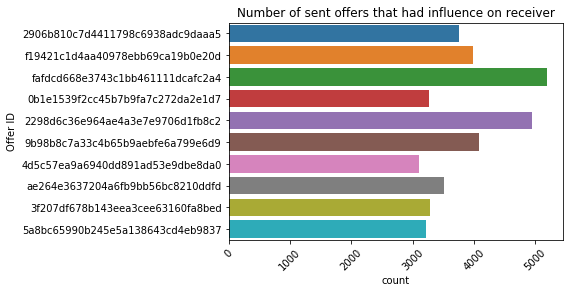

In [41]:
completed_count = df[df['success'] == 1]
completed_count.sort_values(by=['offer_type'])

sns.countplot(y=completed_count['offer id'])
plt.title('Number of sent offers that had influence on receiver')
plt.ylabel('Offer ID')
plt.xticks(rotation = 45)
plt.show();

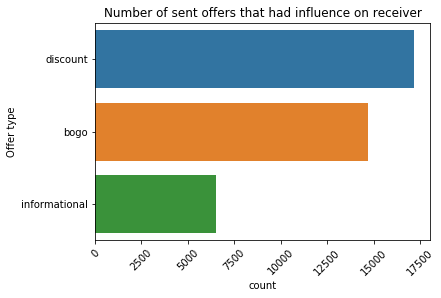

In [42]:
sns.countplot(y=completed_count['offer_type'])
plt.title('Number of sent offers that had influence on receiver')
plt.ylabel('Offer type')
plt.xticks(rotation = 45)
plt.show();

## PREPROCESSING - MACHINE READABLE DATA
___________________________________________

Since machine learning models cannot really read text, we need to transform text data to numbers. We also need to decide what to do with values with null or empty values and scale the data so that it is easier for a model to handle.

In [43]:
print('Columsn with null values:')
df.columns[df.isnull().any()]

Columsn with null values:


Index(['gender', 'income', 'avg_purchase'], dtype='object')

### Cleaning nulls and other strange values

Customer genders can be F(emaile), M(ale) and O(ther), but there are also nulls. After the examination in the beginning we also know if the gender is missing the income and age are also missing.

In [44]:
print('Number of customers without gender: ', 
      len(df[df['gender'].isnull()]), '/', len(df),
      '(', round(len(df[df['gender'].isnull()]) / len(df) * 100, 2) ,'%)')

Number of customers without gender:  9776 / 76277 ( 12.82 %)


The number of customers without personal data is quite big, but if we remove them from the data we still have quite nice amount of data so let's remove all data where there is any data missing. This will also remove the people with strange age (118).

In [45]:
df = df.dropna(subset=['gender', 'income'])

We also seem to have nulls on average purchase column. That means the customer has not bought anything, so setting that number to zero.

In [46]:
df['avg_purchase'] = df['avg_purchase'].fillna(0)

### Encoding text and group features

Now that the data has all values we need I am encoding all texts and 'member since' to numbers. That means we count the unique values of the column and change texts with same values to same number between 0 and the maximum number.

In [47]:
# Changing features to numbers (values between 0 and number of unique values)

from sklearn import preprocessing

def encode_features(data, features):
    
    for feature in features:
        label_encoder = preprocessing.LabelEncoder()
        label_encoder = label_encoder.fit(data[feature])
        data[feature] = label_encoder.transform(data[feature])
        
    return data

In [48]:
features = ['member_since', 'gender', 'offer_type', 'status']
df = encode_features(df.copy(), features)

df.head()

,person,age,gender,income,member_since,avg_purchase,offer id,offer_type,offer_duration,email,mobile,web,social,difficulty,reward,status,success
0,0009655768c64bdeb2e877511632db8f,33,1,72000.0,4,15.950,2906b810c7d4411798c6938adc9daaa5,1,7,1,1,1,0,10,2.0,3,1
3,0009655768c64bdeb2e877511632db8f,33,1,72000.0,4,15.950,f19421c1d4aa40978ebb69ca19b0e20d,0,5,1,1,1,1,5,5.0,3,1
4,0009655768c64bdeb2e877511632db8f,33,1,72000.0,4,15.950,fafdcd668e3743c1bb461111dcafc2a4,1,10,1,1,1,1,10,2.0,3,1
7,0011e0d4e6b944f998e987f904e8c1e5,40,2,57000.0,5,15.892,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,10,1,0,1,0,20,5.0,3,1
8,0011e0d4e6b944f998e987f904e8c1e5,40,2,57000.0,5,15.892,2298d6c36e964ae4a3e7e9706d1fb8c2,1,7,1,1,1,1,7,3.0,3,1


### Scaling numbers

Usually it is good to group data in some way, f.ex. ages to age groups or incomes to income groups. However, I am not doing it this time but instead I scale all numbers to values between 0-1 so that the max value is 1 and min value is 0.

Scaling helps ML models to work better when the differences in values are not that big.

To be able to scale the columns I need to remove person and offer id columns as those are not scaleable. Also, in the eyes of a ML model they are redundant.

In [49]:
del df['person']
del df['offer id']

In [50]:
# scaling numerical features into a normalized range (0 - 1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.astype(float)))

# keep column names and customer_ids
df_scaled.columns=df.columns
df_scaled.index=df.index

df = df_scaled
df.head(10)

,age,gender,income,member_since,avg_purchase,offer_type,offer_duration,email,mobile,web,social,difficulty,reward,status,success
0,0.180723,0.5,0.466667,0.8,0.035329,0.5,0.571429,0.0,1.0,1.0,0.0,0.50,0.2,0.75,1.0
3,0.180723,0.5,0.466667,0.8,0.035329,0.0,0.285714,0.0,1.0,1.0,1.0,0.25,0.5,0.75,1.0
4,0.180723,0.5,0.466667,0.8,0.035329,0.5,1.000000,0.0,1.0,1.0,1.0,0.50,0.2,0.75,1.0
7,0.265060,1.0,0.300000,1.0,0.035201,0.5,1.000000,0.0,0.0,1.0,0.0,1.00,0.5,0.75,1.0
8,0.265060,1.0,0.300000,1.0,0.035201,0.5,0.571429,0.0,1.0,1.0,1.0,0.35,0.3,0.75,1.0
11,0.265060,1.0,0.300000,1.0,0.035201,0.0,0.571429,0.0,1.0,1.0,0.0,0.25,0.5,0.75,1.0
12,0.493976,0.0,0.666667,0.6,0.054505,0.0,0.285714,0.0,1.0,1.0,1.0,0.50,1.0,0.75,1.0
14,0.493976,0.0,0.666667,0.6,0.054505,0.0,0.571429,0.0,1.0,0.0,1.0,0.50,0.0,0.25,0.0
15,0.493976,0.0,0.666667,0.6,0.054505,0.5,1.000000,0.0,1.0,1.0,1.0,0.50,0.2,0.75,1.0
16,0.493976,0.0,0.666667,0.6,0.054505,0.5,1.000000,0.0,1.0,1.0,1.0,0.50,0.2,0.75,1.0


Now the data is ready for models!

### Checking correlations

Currently we have 13 features we're using for predictions. Let's see how they correlate to each other. In case some of them are highly correlating we can remove them.

In [51]:
features = df.loc[:, df.columns != 'success'] # all columns except labels

features.corr()

,age,gender,income,member_since,avg_purchase,offer_type,offer_duration,email,mobile,web,social,difficulty,reward,status
age,1.000000,-0.141769,0.305156,-0.010001,0.193606,0.004055,-0.003150,NaN,-0.000239,-0.000266,-0.000272,-0.004088,0.076166,0.056993
gender,-0.141769,1.000000,-0.219368,-0.005159,-0.173872,-0.000186,0.004168,NaN,0.001708,0.002085,0.000335,0.000614,-0.110927,-0.079065
income,0.305156,-0.219368,1.000000,-0.026660,0.478407,-0.001305,-0.002406,NaN,0.002979,-0.004473,0.004771,-0.000858,0.174459,0.126748
member_since,-0.010001,-0.005159,-0.026660,1.000000,-0.042312,0.001790,-0.000641,NaN,0.000363,0.001381,0.004258,-0.000513,-0.112126,-0.119294
avg_purchase,0.193606,-0.173872,0.478407,-0.042312,1.000000,0.000708,-0.004627,NaN,0.000039,-0.008891,0.009148,-0.000463,0.212080,0.172745
offer_type,0.004055,-0.000186,-0.001305,0.001790,0.000708,1.000000,-0.243726,NaN,-0.089271,-0.131216,-0.216816,-0.351369,-0.497506,-0.130261
offer_duration,-0.003150,0.004168,-0.002406,-0.000641,-0.004627,-0.243726,1.000000,NaN,-0.531442,0.340997,-0.185837,0.809257,0.112222,0.076267
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,-0.000239,0.001708,0.002979,0.000363,0.000039,-0.089271,-0.531442,NaN,1.000000,-0.167925,0.409566,-0.742892,-0.010798,0.093663
web,-0.000266,0.002085,-0.004473,0.001381,-0.008891,-0.131216,0.340997,NaN,-0.167925,1.000000,-0.410007,0.243572,-0.051658,-0.068762


In [52]:
# Seems like the email is always the same number so let's remove it.
del features['email']

Text(0.5,1,'Correlation between different features')

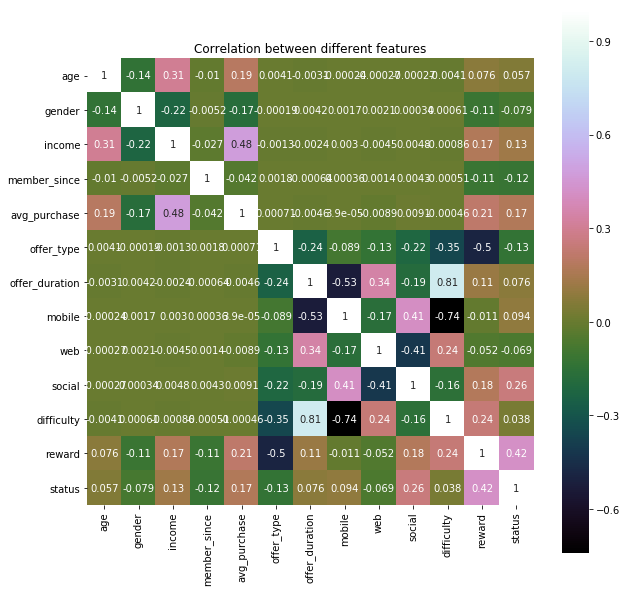

In [53]:
plt.figure(figsize=(10,10))
sns.heatmap(features.corr(), vmax=1, square=True, annot=True, cmap='cubehelix')

plt.title('Correlation between different features')

## MACHINE LEARNING MODELS
______________________________

As a first step let's split the dataframe to
- features and labels
- train data (for model training) and test data (to test if model works correctly)

In [54]:
# Splitting features and lables/target

features = features
target = df['success']

In [55]:
# Splitting data to train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

print('Count of rows in train data: ', len(X_train), '(', round(len(X_train) / len(df) * 100, 2) ,'%)')
print('Count of rows in train data: ', len(X_test), '(', round(len(X_test) / len(df) * 100, 2) ,'%)')

Count of rows in train data:  49875 ( 75.0 %)
Count of rows in train data:  16626 ( 25.0 %)


### Benchmark model

As the first machine learning model let's see how a basic decision tree handles the task.

In [56]:
from sklearn import tree

model_tree = tree.DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
from sklearn.metrics import accuracy_score

tree_prediction = model_tree.predict(X_test)
print('Tree model accuracy score: ', accuracy_score(y_test, tree_prediction))

Tree model accuracy score:  0.908637074462


Not bad! Let's see how it went wrong in a confusion matrix.

In [58]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, tree_prediction)

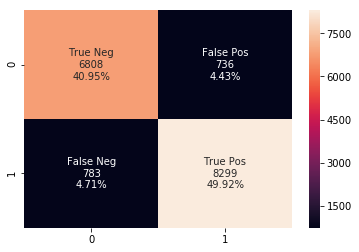

In [59]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

### Testing other models

#### Random Forest Classifier

Tree classifier is pretty simple. The next version of it is to use several of them together. This model is called random forest classifier.

In [60]:
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier()
model_RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
rfc_prediction = model_RFC.predict(X_test)
print('Random Forest Classifier accuracy score: ', accuracy_score(y_test, rfc_prediction))

Random Forest Classifier accuracy score:  0.908576927704


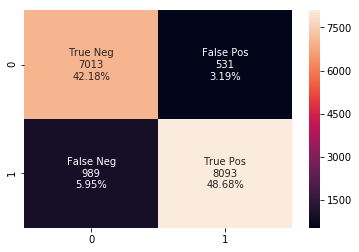

In [62]:
cf_matrix = confusion_matrix(y_test, rfc_prediction)

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

The RandomForestClassifier was better when predicting true negatives and false positives but worse when it comes to false negative and true positive.

#### KNeighborsClassifier

In [63]:
from sklearn.neighbors import KNeighborsClassifier

kneigh_model = KNeighborsClassifier()
kneigh_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [64]:
kneigh_prediction = kneigh_model.predict(X_test)
print('Random Forest Classifier accuracy score: ', accuracy_score(y_test, kneigh_prediction))

Random Forest Classifier accuracy score:  0.903163719476


Looks like our benchmark model predicted 90% of the rows correctly, not bad at all!

#### Multilayer Perceptron Classifier

Let's also create a small neural network ourselves and see how that works.

In [65]:
from sklearn.neural_network import MLPClassifier

mlpc_model = MLPClassifier(
    solver='adam', 
    alpha=1e-5, 
    activation='relu', 
    learning_rate='adaptive',
    early_stopping=True,
    hidden_layer_sizes=(8), 
    random_state=1, 
    max_iter=5000 )

mlpc_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=8, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [66]:
mlpc_prediction = mlpc_model.predict(X_test)
print(accuracy_score(y_test, mlpc_prediction))

0.912426320221


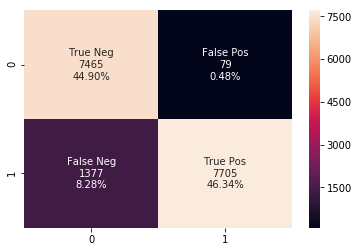

In [67]:
cf_matrix = confusion_matrix(y_test, mlpc_prediction)

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

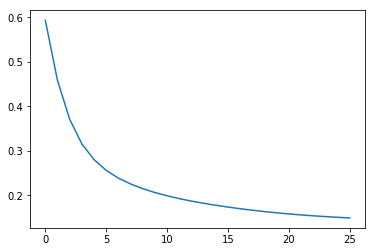

In [68]:
# Just for fun let's see the loss curve of the model. 
# That describes how much it used to predict wrong during training.

plt.plot(mlpc_model.loss_curve_)
plt.show()

This model seems to perform a bit better than the others so let's try to adjust it to be even better. As we can see it still gives a lot of false negatives.

### Fine tuning the best model

It takes forever to test different hyperparameter combinations so it's better to do it with code. Here I am using Grid Search CV to find the best possible combination from the suggestions I am giving to it.

In [69]:
mlpc = MLPClassifier(max_iter=500)

# Defining hyper parameter tuning values
parameter_space = {
    'hidden_layer_sizes': [(16), (32), (64), (8,16)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.002, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

In [70]:
from sklearn.model_selection import GridSearchCV

# Finding best combination
clf = GridSearchCV(mlpc, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [16, 32, 64, (8, 16)], 'activation': ['relu'], 'solver': ['adam'], 'alpha': [0.0001, 0.002, 0.05], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f %r" % (mean, params))

0.9155 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 16, 'learning_rate': 'constant', 'solver': 'adam'}
0.9154 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 16, 'learning_rate': 'adaptive', 'solver': 'adam'}
0.9152 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 32, 'learning_rate': 'constant', 'solver': 'adam'}
0.9136 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 32, 'learning_rate': 'adaptive', 'solver': 'adam'}
0.9151 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 64, 'learning_rate': 'constant', 'solver': 'adam'}
0.9154 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 64, 'learning_rate': 'adaptive', 'solver': 'adam'}
0.9155 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8, 16), 'learning_rate': 'constant', 'solver': 'adam'}
0.9155 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8, 16), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.9156 {'activation': 'relu', 

In [77]:
# Best result
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.002, 'hidden_layer_sizes': 32, 'learning_rate': 'constant', 'solver': 'adam'}


## Using the best model found

Now that we have found bets combination of hyperparameters let's do a final test with the test set.

In [79]:
clf_prediction = clf.predict(X_test)
print(accuracy_score(y_test, clf_prediction))

0.912666907254


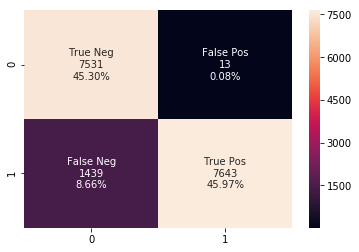

In [81]:
cf_matrix = confusion_matrix(y_test, clf_prediction)

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='')

Looking great, 91% of the predictions were correct! We also managed to improve the score from the benchmark model (90%) by 1%. Sounds small, but that's around 120 correct predictions more. However, the decision tree classifier did not give as many false negatives as this model does and was a bit better when it comes to finding true positives. The multilayer perceptron classifier found true negatives better and provided less false positives. 

However, the final model is also working in a nice way: false positives (meaning a customer that was predicted to be influenced buys nothing) are super low and that means there wouldn't be offers sent for nothing. False negatives (customers that were predicted not to be influenced by an offer buy something) are not as bad, but obviously you wouldn't send offers for them so it would be good to improve the model more.

Finally, we can also throw some random numbers to the model and it predicts the outcome.

In [102]:
test_person_row = [[0.421687, 0.0, 0.485664, 0.2, 0.032458, 1.0, 0.142857, 1.0, 0.0, 0.0, 0.0, 0.0, 0.75]]
clf.predict(test_person_row)

array([ 0.])

That means with those numbers the model predicts the customer would not buy anything so in the end we found pretty nice and usable model.


**Examples of improvements that could be done:**
- Trying to find out why false negatives happen more often than false positives
- The model could also predict the probability if offer will be viewed, not just completed
- More features could be added, f.ex. minimum and maximum purchases, offer opening percentage, offer completion percentage, how did a customer react to previous offers sent to them, did offer types matter, would it be enough to send an informative offer to someone...
- Features could be selected better to have less correlation between them